# Lip Reading Project
@author : Raby3

##Dependencies##

In [ ]:
%%capture
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
from typing import List

In [ ]:
#Avoiding out of memory errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


##Loading Data##

In [ ]:
import gdown

In [ ]:
%%capture
#Loading Videos and aligned transcriptions (Annotaions)
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [ ]:
#Try the Lip region isolation with Dlib

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #isolate mouth region - Satitically
    cap.release()                              #Original paper uses Dlib

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std #All pixels are Scaled

In [ ]:
#Define Vocab
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
#Mapping each word to an index and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size: {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size: 40)


In [ ]:
#Loading Alignment
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path:str):
  path=bytes.decode(path.numpy())
  file_name=path.split('/')[-1].split('.')[0]
  video_path=os.path.join('data','s1',f'{file_name}.mpg')
  alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
  frames=load_video(video_path)
  alignments=load_alignments(alignment_path)
  return frames, alignments

In [ ]:
test='/content/data/s1/bbaf4p.mpg'
tf.convert_to_tensor(test).numpy().decode('UTF8').split('/')[-1].split('.')[0]

'bbaf4p'

tf.Tensor(b'bin blue at f four please', shape=(), dtype=string)


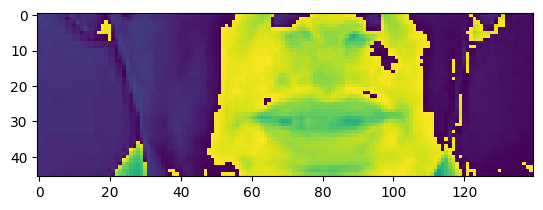

In [ ]:
frames,alignements=load_data(tf.convert_to_tensor(test))
plt.imshow(frames[20]) #Due to Scaling the image appears in this way
print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignements).numpy()]))

In [ ]:
def mappable_function(video_path)->List[str]: #Wraps Load data function in a py_func
  return tf.py_function(load_data, [video_path], (tf.float32, tf.int64))

##Creating Data Pipeline##

In [ ]:
"""data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function) # Turns the path into actual data
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40])) #Takes a pair of video,alignment
                                                                      #Keep Video safe but only 75 frames
                                                                      #Pads the sequence into 40
data=data.prefetch(tf.data.AUTOTUNE)"""
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()
#plt.imshow(frames[20])
len(frames)
alignments #Variable Length so we need padding
#print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments).numpy()]))

array([[19,  5, 20, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39,  3, 39,  6,
         9, 22,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39, 16,
        39,  6, 15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
#Extracting an example of Data
sample = data.as_numpy_iterator()
val = sample.next()
fv = (val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv, duration=100)


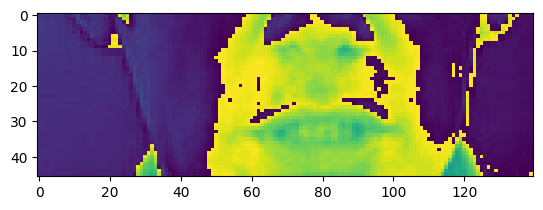

In [ ]:
#videos,1stvideo of batsh ,1st frame in vid
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(val[1][0]).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by b three again'>

##Building the Deep Neural Network##

In [ ]:
"""# First, uninstall current packages to avoid conflicts
!pip uninstall -y tensorflow tensorflow-gpu opencv-python

# Install specific older versions from approximately 2 years ago
# TensorFlow 2.9.0 was released in May 2022
!pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0

# OpenCV 4.6.0 was released in mid-2022
!pip install opencv-python==4.6.0.66

# Force restart runtime after installations to properly initialize new versions
import os
os._exit(0)"""

# After restart, use this code block to import libraries and verify versions
import tensorflow as tf
import cv2
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, LSTM, Dense, Dropout, Bidirectional,
    MaxPool3D, Activation, Reshape, SpatialDropout3D,
    BatchNormalization, TimeDistributed, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Print version information to verify setup
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

# Verify GPU availability (if using GPU runtime)
print("\nGPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.9.0
OpenCV version: 4.6.0
NumPy version: 1.26.4

GPU Available: []


In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()  # Initiate
model.add(Conv3D(128, 3, activation='relu', input_shape=(75, 46, 140, 1), padding='same')) #Relu for none Linearity
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, activation='relu', padding='same'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, activation='relu', padding='same'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5)) #Regularisation

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
#Vocab Size +1 to handle our special token // Output is 75,41
#41 One hot encoded represenation of our characters

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 11, 35, 75)    518475    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 75, 5, 17, 75)    0

In [ ]:
5*17*75

6375

In [ ]:
res=model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [ ]:
res[0].shape

(75, 41)

In [ ]:
tf.argmax(res[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([20, 20, 20, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14])>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in res[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'tttnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'>

##Training##

In [ ]:
#Making a scheduler ... controlling the Learning aswe go through more and more epochs
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
#Defining Loss Function : CTC Loss
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
#Making Callbacks --- See results and comare in every Epoch
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
#Making Callbakcs
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  1/450 [..............................] - ETA: 7:26:43 - loss: 229.3200

##Predictions and results##

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=293a2cef-393d-4984-88e0-6e20e9b4f41d
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 114MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()
test_data.
#sample=test_data.next()
#sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

##Vid Test##

In [ ]:
sample = load_data(tf.convert_to_tensor('content/data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]